In [107]:
import ipywidgets as widgets
import sys
from pathlib import Path
import os
import importlib


module_path='preprocessing/day_intervals_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)

module_path='utils'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='preprocessing/hosp_module_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='model'
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)
root_dir = os.path.dirname(os.path.abspath('UserInterface.ipynb'))
data_dir = '/datasets/MIMIC-IV/physionet.org/files'
import day_intervals_cohort
from day_intervals_cohort import *

import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

import data_generation_icu

import data_generation
import evaluation

import feature_selection_hosp
from feature_selection_hosp import *

# import train
# from train import *


import ml_models
from ml_models import *

import dl_train
from dl_train import *

import tokenization
from tokenization import *


import behrt_train
from behrt_train import *

import feature_selection_icu
from feature_selection_icu import *
import fairness
import callibrate_output

In [108]:
%load_ext autoreload
%autoreload 2

importlib.reload(day_intervals_cohort)
import day_intervals_cohort
from day_intervals_cohort import *

importlib.reload(day_intervals_cohort_v2)
import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

importlib.reload(data_generation_icu)
import data_generation_icu
importlib.reload(data_generation)
import data_generation

importlib.reload(feature_selection_hosp)
import feature_selection_hosp
from feature_selection_hosp import *

importlib.reload(feature_selection_icu)
import feature_selection_icu
from feature_selection_icu import *

importlib.reload(tokenization)
import tokenization
from tokenization import *

importlib.reload(ml_models)
import ml_models
from ml_models import *

importlib.reload(dl_train)
import dl_train
from dl_train import *

importlib.reload(behrt_train)
import behrt_train
from behrt_train import *

importlib.reload(fairness)
import fairness

importlib.reload(callibrate_output)
import callibrate_output

importlib.reload(evaluation)
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
def set_seed(seed):
    """set random seed."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Welcome to your MIMIC-IV Project

## 10. Running BEHRT
Below we integrate the implementation of BEHRT in our pipeline.
We perform pre-procesing needed to run BEHRT model. https://github.com/deepmedicine/BEHRT

Few things to note before running BEHRT -
- The numerical values are binned into quantiles.
- BEHRT has recommended maximum number of events per sample to be 512. 
    So feature selection is important so that number of events per sample does not exceed 512.
- The model is quite computationally heavy so it requires a GPU.

The output files for BEHRT will be saved in ./data/behrt/ folder

**Please run below cell to to pre-process and run BEHRT on the selected cohort**

In [172]:
importlib.reload(tokenization)
import tokenization
from tokenization import *

import behrt_train
from behrt_train import *

In [173]:
data_icu = True
diag_flag = True
proc_flag = False
out_flag = False
chart_flag = True
med_flag = True

In [174]:
if data_icu:
    token=tokenization.BEHRT_models(data_icu,diag_flag,proc_flag,out_flag,chart_flag,med_flag,False)
    #tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds, meds_labels, n_meds =token.tokenize()
    #data2_dir = '/datasets/MIMIC-IV/'
    data2_dir = '/h/chloexq/los-prediction/pipeline/data/features/'
    n_meds = 270
    names = ['tokenized_src', 'tokenized_age', 'tokenized_gender', 'tokenized_ethni', 'tokenized_ins', 'tokenized_labels', 'labs', 'meds']
    #meds_labels = np.load(data2_dir + 'data/token/'+'meds_labels_5000.npy', allow_pickle=True)
    meds_labels = np.load(data2_dir + 'meds_labels_5000.npy', allow_pickle=True)
    all_df = []
    for i in range(len(names)):
        #df = pd.read_csv(data2_dir + 'data/token/'+names[i]+'_5000.csv', index_col=0)
        df = pd.read_csv(data2_dir + names[i]+'_5000.csv', index_col=0)
        all_df.append(df)
    tokenized_src, tokenized_age, tokenized_gender, tokenized_ethni, tokenized_ins, tokenized_labels, labs, meds = all_df

In [175]:
model_config = {
    'vocab_size': int(tokenized_src.max().max() + 1), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': int(tokenized_age.max().max() + 1), # number of vocab for age embedding
    'gender_vocab_size': 2 + 1, # TODO: +1 for missing values
    'ethni_vocab_size': int(tokenized_ethni.max().max()) + 1,
    'ins_vocab_size': int(tokenized_ins.max().max()) + 1,
    'max_position_embedding': tokenized_src.shape[1], # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 6, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 256, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'number_output' : 1,
    'number_meds': n_meds,
}

In [271]:
conf = BertConfig(model_config)
behrt = BertForEHRPrediction(conf, model_config['number_output'])
device = "cuda:0" if torch.cuda.is_available() else "cpu"
behrt.load_state_dict(torch.load("./saved_models/checkpoint/DAB_1/behrt", map_location=device))

<All keys matched successfully>

In [272]:
behrt

BertForEHRPrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(2343, 288)
      (segment_embeddings): Embedding(2, 288)
      (age_embeddings): Embedding(93, 288)
      (gender_embeddings): Embedding(3, 288)
      (ethnicity_embeddings): Embedding(34, 288)
      (ins_embeddings): Embedding(4, 288)
      (posi_embeddings): Embedding(512, 288)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=288, out_features=288, bias=True)
              (key): Linear(in_features=288, out_features=288, bias=True)
              (value): Linear(in_features=288, out_features=288, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(

In [273]:
with open('./data/dict/condVocab.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

In [274]:
mask = ['_' in i for i in list(vocab_dict['token2idx'].keys())]

In [275]:
dyn_feature_keys = np.array(list(vocab_dict['token2idx'].keys()))[mask]

In [276]:
feature_df = pd.read_csv('dynamic_item_dict_short_263.csv')

In [277]:
feature_df

,itemid,type,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,221749.0,MEDS,Phenylephrine,Phenylephrine,inputevents,Medications,mg,Solution,NaN,NaN
1,222168.0,MEDS,Propofol,Propofol,inputevents,Medications,mg,Solution,NaN,NaN
2,221906.0,MEDS,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,NaN,NaN
3,225942.0,MEDS,Fentanyl (Concentrate),Fentanyl (Concentrate),inputevents,Medications,mg,Solution,NaN,NaN
4,222056.0,MEDS,Nitroglycerin,Nitroglycerin,inputevents,Medications,mg,Solution,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
258,227452.0,CHART,Tobramycin (Trough),Tobramycin (Trough),chartevents,Labs,NaN,Numeric with tag,NaN,NaN
259,227448.0,CHART,Gentamicin (Peak),Gentamicin (Peak),chartevents,Labs,NaN,Numeric with tag,NaN,NaN
260,227450.0,CHART,Tobramycin (Peak),Tobramycin (Peak),chartevents,Labs,NaN,Numeric with tag,NaN,NaN
261,227453.0,CHART,Vancomycin (Peak),Vancomycin (Peak),chartevents,Labs,NaN,Numeric with tag,NaN,NaN


In [278]:
dyn_feature_keys

array(['165_2', '84_1', '6_3', '256_3', '7_3', '167_2', '4_1', '254_3',
       '59_1', '236_1', '169_2', '147_2', '120_3', '152_3', '5_2', '46_0',
       '16_2', '91_0', '150_3', '104_1', '78_3', '207_1', '166_3',
       '233_3', '192_1', '86_2', '86_0', '115_0', '129_1', '151_0',
       '152_0', '223_0', '48_2', '85_0', '97_2', '31_0', '1_3', '163_0',
       '196_3', '229_2', '26_2', '241_3', 'dyn_71', '58_2', '191_1',
       '2_2', '243_0', '100_1', '117_3', '223_1', '256_2', '176_1',
       '230_0', '51_0', '65_0', '243_3', '81_1', '181_1', '16_0', '127_1',
       '130_3', '27_0', '79_0', '127_0', '150_2', '189_3', '72_0',
       '188_1', '6_0', '257_0', '210_2', '147_0', '157_3', '45_0',
       '184_3', '74_3', '159_2', '36_0', '167_0', '41_2', '139_0',
       '102_0', '30_0', '80_0', '139_2', '160_1', '20_0', '244_1',
       '133_0', '182_0', '21_1', '254_1', '70_2', '231_0', '226_2',
       '156_0', '244_2', '258_0', '120_1', '183_2', '34_1', '99_0',
       '96_0', '249_3', '226_

In [279]:
ind = []
level = []
for i in dyn_feature_keys:
    i_0, i_1 = i.split('_')
    if i_0 == 'dyn':
        ind.append(int(i_1))
        level.append(-1)
    else:
        ind.append(int(i_0))
        level.append(int(i_1))

In [280]:
names = [feature_df.iloc[i, 2] for i in ind]
type = [feature_df.iloc[i, 5] for i in ind]

In [281]:
emb_id = [vocab_dict['token2idx'][i] for i in dyn_feature_keys]

In [282]:
df_key = pd.DataFrame()
df_key['df_id'] = ind
df_key['level'] = level
df_key['feature'] = names
df_key['emb_id'] = emb_id
df_key['type'] = type

In [283]:
df_key

,df_id,level,feature,emb_id,type
0,165,2,Absolute Count - Eos,1359,Labs
1,84,1,O2 saturation pulseoxymetry,1360,Respiratory
2,6,3,Midazolam (Versed),1361,Medications
3,256,3,Orthostatic BPd standing,1362,Routine Vital Signs
4,7,3,Octreotide,1363,Medications
...,...,...,...,...,...
979,32,2,Amiodarone,2338,Medications
980,79,3,Non Invasive Blood Pressure systolic,2339,Routine Vital Signs
981,103,2,Arterial Blood Pressure systolic,2340,Routine Vital Signs
982,205,0,Pinsp (Draeger only),2341,Respiratory


In [284]:
meds_embs = behrt.bert.embeddings.word_embeddings.weight.data[df_key['emb_id'].values, :].numpy()
meds_embs.shape

(984, 288)

In [285]:
import umap
import seaborn as sns

In [286]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(meds_embs)

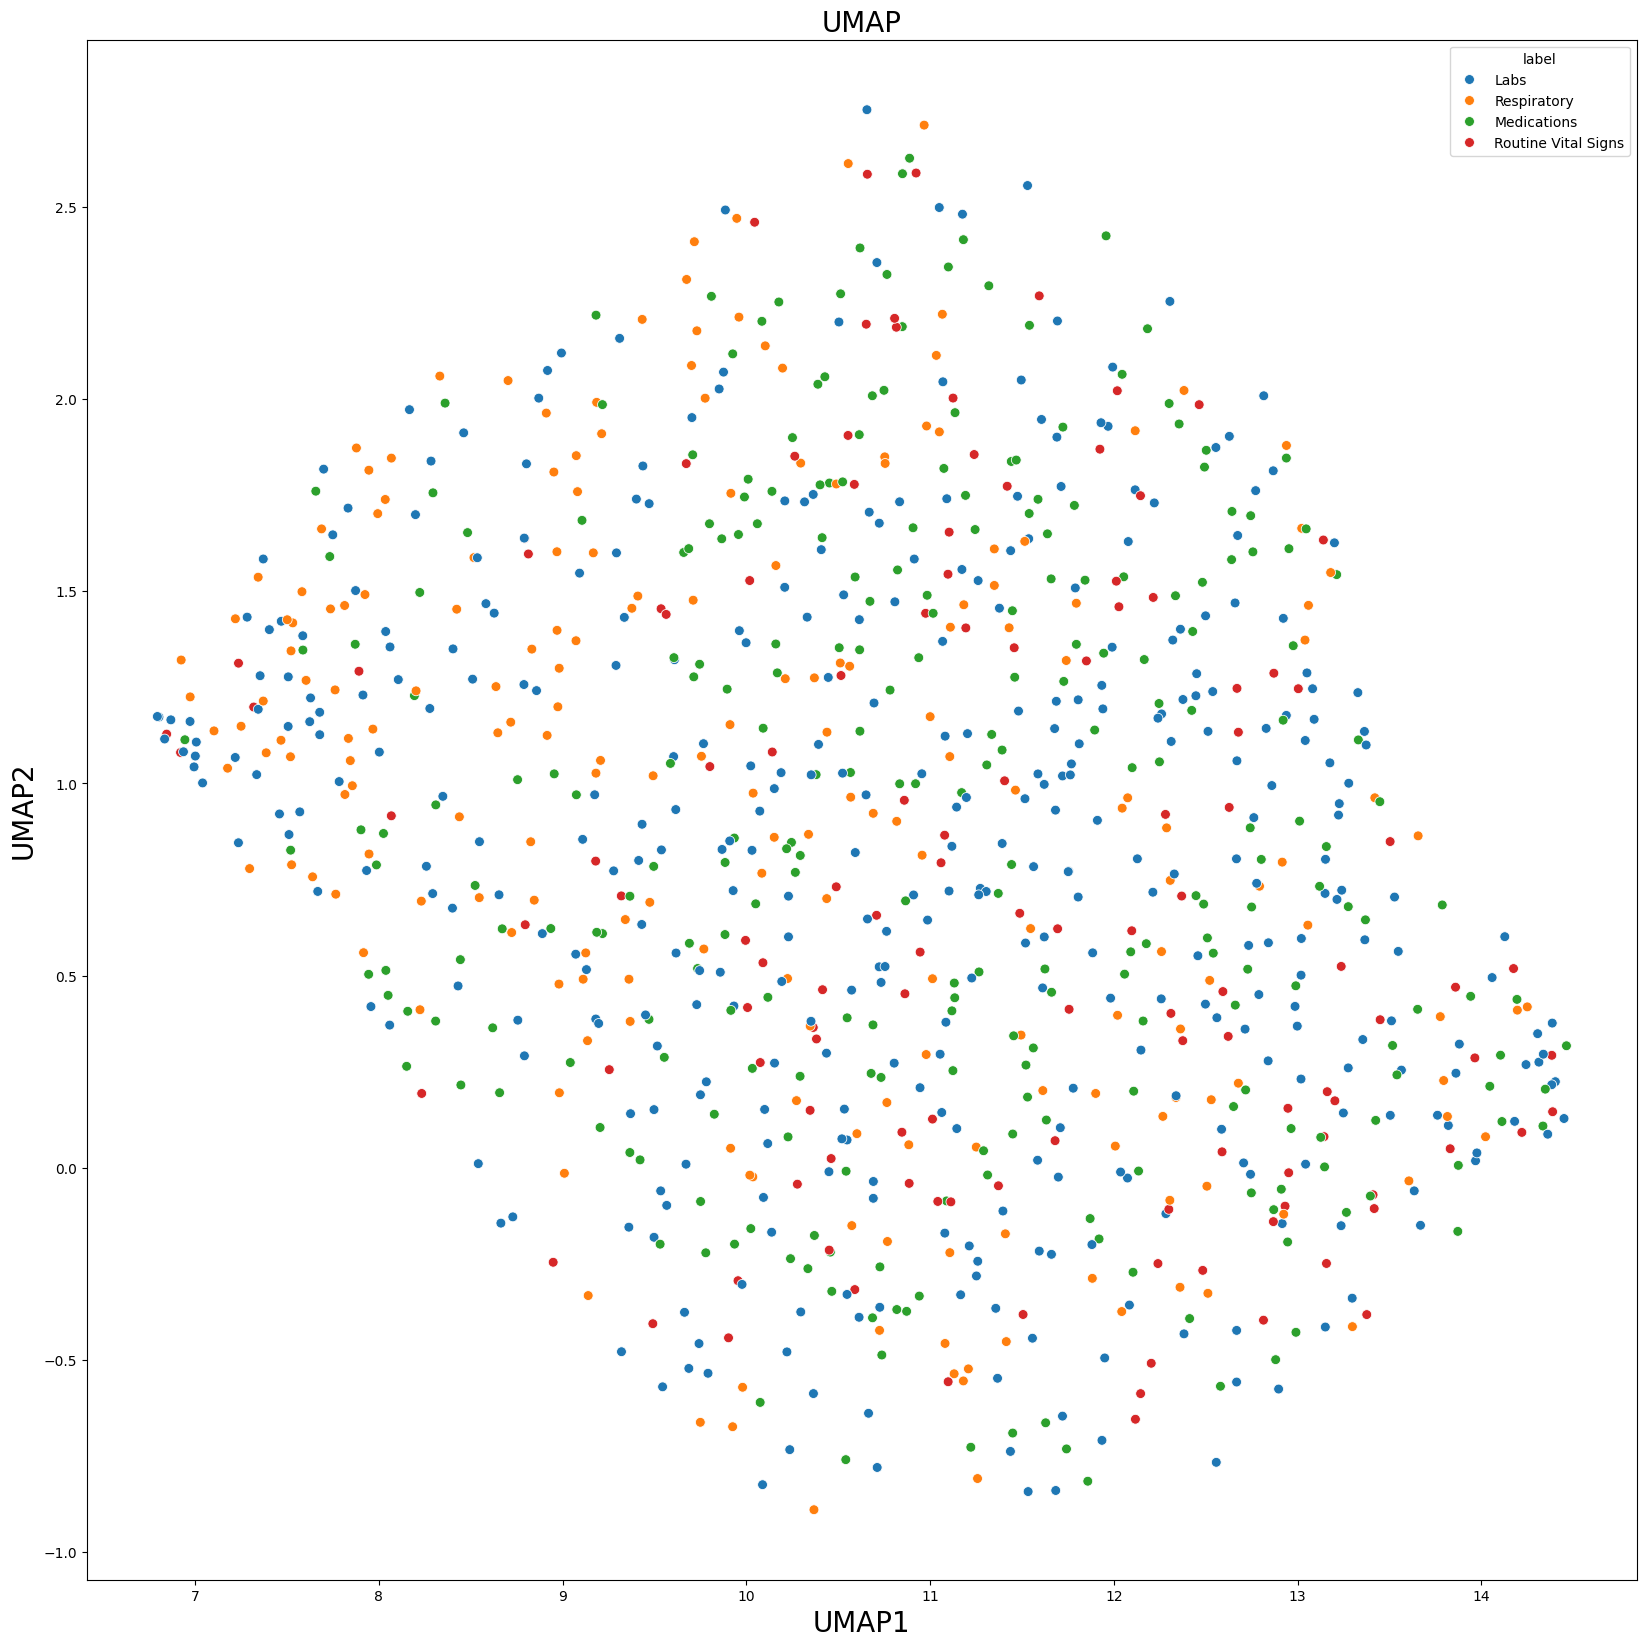

In [287]:
plt.figure(figsize=(20,20))
df = pd.DataFrame(X_umap, columns = ['x', 'y'])
df['label'] = df_key['type'].astype(str)
scatter = sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'label', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()

In [234]:
import faiss

In [288]:
faiss_index = faiss.IndexFlatL2(meds_embs.shape[1])
faiss_index.add(meds_embs)
D, I = faiss_index.search(meds_embs, 6)

In [289]:
columns = ['nn_'+str(i) for i in range(6)]
df_nn = pd.DataFrame(I, columns = columns)

In [290]:
df_nn = df_nn.replace(dict(zip(df_key.index.tolist(), df_key.feature.tolist())))

In [291]:
df_all = pd.concat((df_key, df_nn), axis=1)

In [292]:
df_all

,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
0,165,2,Absolute Count - Eos,1359,Labs,Absolute Count - Eos,Ionized Calcium,Peak Insp. Pressure,Potassium (serum),Creatinine (serum),Vasopressin
1,84,1,O2 saturation pulseoxymetry,1360,Respiratory,O2 saturation pulseoxymetry,Arterial Blood Pressure systolic,Epinephrine,Acetylcysteine,Non Invasive Blood Pressure systolic,Arterial Blood Pressure mean
2,6,3,Midazolam (Versed),1361,Medications,Midazolam (Versed),Acetaminophen-IV,Tidal Volume (spontaneous),Manual Blood Pressure Diastolic Right,Tobramycin (Peak),TCO2 (calc) Venous
3,256,3,Orthostatic BPd standing,1362,Routine Vital Signs,Orthostatic BPd standing,Flow Rate (L/min),Orthostatic HR standing,Fibrinogen,Total Granulocyte Count (TGC),Naloxone (Narcan)
4,7,3,Octreotide,1363,Medications,Octreotide,T High (APRV),Pentobarbital,CK-MB fraction (%),Amiodarone 450/250,Orthostatic BPs standing
...,...,...,...,...,...,...,...,...,...,...,...
979,32,2,Amiodarone,2338,Medications,Amiodarone,Manual Blood Pressure Diastolic Right,Clevidipine (Cleviprex),Gentamicin (Trough),Rocuronium,LDL measured
980,79,3,Non Invasive Blood Pressure systolic,2339,Routine Vital Signs,Non Invasive Blood Pressure systolic,Hemoglobin,O2 saturation pulseoxymetry,Sodium (whole blood),Sed Rate,Temperature Fahrenheit
981,103,2,Arterial Blood Pressure systolic,2340,Routine Vital Signs,Arterial Blood Pressure systolic,Non Invasive Blood Pressure diastolic,Fentanyl,PH (Arterial),O2 Flow,Gentamicin (Peak)
982,205,0,Pinsp (Draeger only),2341,Respiratory,Pinsp (Draeger only),Orthostatic HR sitting,Arterial Blood Pressure mean,Tobramycin (Peak),PCV Level,Orthostatic HR standing


In [293]:
df_all[df_all['type']=='Medications']

,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
2,6,3,Midazolam (Versed),1361,Medications,Midazolam (Versed),Acetaminophen-IV,Tidal Volume (spontaneous),Manual Blood Pressure Diastolic Right,Tobramycin (Peak),TCO2 (calc) Venous
4,7,3,Octreotide,1363,Medications,Octreotide,T High (APRV),Pentobarbital,CK-MB fraction (%),Amiodarone 450/250,Orthostatic BPs standing
6,4,1,Nitroglycerin,1365,Medications,Nitroglycerin,Sed Rate,PSV Level,Absolute Neutrophil Count,PH (Arterial),PH (dipstick)
8,59,1,Morphine Sulfate,1367,Medications,Morphine Sulfate,Gentamicin (Peak),Gentamicin (Trough),PCV Level,LDL measured,Phenytoin (Dilantin)
14,5,2,Heparin Sodium,1373,Medications,Heparin Sodium,Orthostatic HR standing,Gentamicin (Peak),O2 Flow,Total Granulocyte Count (TGC),Albumin
...,...,...,...,...,...,...,...,...,...,...,...
966,44,2,Bumetanide (Bumex),2325,Medications,Bumetanide (Bumex),Transpulmonary Pressure (Exp. Hold),Cholesterol,Clevidipine (Cleviprex),Heparin Sodium (Impella),Orthostatic HR standing
974,7,0,Octreotide,2333,Medications,Octreotide,Arterial Blood Pressure mean,Manual Blood Pressure Systolic Right,LDL measured,Manual Blood Pressure Systolic Left,Manual Blood Pressure Systolic Right
976,26,1,Lidocaine,2335,Medications,Lidocaine,PH (dipstick),Tidal Volume (set),TCO2 (calc) Venous,Calcium non-ionized,P Low (APRV)
978,39,2,Treprostinil (Remodulin),2337,Medications,Treprostinil (Remodulin),Nitric Oxide,Magnesium Sulfate (OB-GYN),Nicardipine 40mg/200,Arterial Blood Pressure mean,Arterial Blood Pressure mean


In [294]:
df_all[df_all['type']=='Medications']

,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
2,6,3,Midazolam (Versed),1361,Medications,Midazolam (Versed),Acetaminophen-IV,Tidal Volume (spontaneous),Manual Blood Pressure Diastolic Right,Tobramycin (Peak),TCO2 (calc) Venous
4,7,3,Octreotide,1363,Medications,Octreotide,T High (APRV),Pentobarbital,CK-MB fraction (%),Amiodarone 450/250,Orthostatic BPs standing
6,4,1,Nitroglycerin,1365,Medications,Nitroglycerin,Sed Rate,PSV Level,Absolute Neutrophil Count,PH (Arterial),PH (dipstick)
8,59,1,Morphine Sulfate,1367,Medications,Morphine Sulfate,Gentamicin (Peak),Gentamicin (Trough),PCV Level,LDL measured,Phenytoin (Dilantin)
14,5,2,Heparin Sodium,1373,Medications,Heparin Sodium,Orthostatic HR standing,Gentamicin (Peak),O2 Flow,Total Granulocyte Count (TGC),Albumin
...,...,...,...,...,...,...,...,...,...,...,...
966,44,2,Bumetanide (Bumex),2325,Medications,Bumetanide (Bumex),Transpulmonary Pressure (Exp. Hold),Cholesterol,Clevidipine (Cleviprex),Heparin Sodium (Impella),Orthostatic HR standing
974,7,0,Octreotide,2333,Medications,Octreotide,Arterial Blood Pressure mean,Manual Blood Pressure Systolic Right,LDL measured,Manual Blood Pressure Systolic Left,Manual Blood Pressure Systolic Right
976,26,1,Lidocaine,2335,Medications,Lidocaine,PH (dipstick),Tidal Volume (set),TCO2 (calc) Venous,Calcium non-ionized,P Low (APRV)
978,39,2,Treprostinil (Remodulin),2337,Medications,Treprostinil (Remodulin),Nitric Oxide,Magnesium Sulfate (OB-GYN),Nicardipine 40mg/200,Arterial Blood Pressure mean,Arterial Blood Pressure mean


In [295]:
df_all.to_csv('df_DAB_1.csv')

In [296]:
df_0 = pd.read_csv('df_NO_DAB.csv')
df_1 = pd.read_csv('df_DAB_1.csv')

In [297]:
df_0

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
0,0,165,2,Absolute Count - Eos,1359,Labs,Absolute Count - Eos,Peak Insp. Pressure,Ionized Calcium,Vasopressin,Mixed Venous O2% Sat,Non Invasive Blood Pressure systolic
1,1,84,1,O2 saturation pulseoxymetry,1360,Respiratory,O2 saturation pulseoxymetry,Arterial Blood Pressure systolic,Epinephrine,Non Invasive Blood Pressure systolic,Acetylcysteine,PH (dipstick)
2,2,6,3,Midazolam (Versed),1361,Medications,Midazolam (Versed),Acetaminophen-IV,Tidal Volume (spontaneous),Tobramycin (Peak),Manual Blood Pressure Diastolic Right,Cholesterol
3,3,256,3,Orthostatic BPd standing,1362,Routine Vital Signs,Orthostatic BPd standing,Flow Rate (L/min),Orthostatic HR standing,Fibrinogen,Total Granulocyte Count (TGC),Rocuronium
4,4,7,3,Octreotide,1363,Medications,Octreotide,Pentobarbital,CK-MB fraction (%),T High (APRV),Amiodarone 450/250,Differential-Lymphs
...,...,...,...,...,...,...,...,...,...,...,...,...
979,979,32,2,Amiodarone,2338,Medications,Amiodarone,Manual Blood Pressure Diastolic Right,Clevidipine (Cleviprex),Transpulmonary Pressure (Exp. Hold),Temperature Celsius,PeCO2
980,980,79,3,Non Invasive Blood Pressure systolic,2339,Routine Vital Signs,Non Invasive Blood Pressure systolic,O2 saturation pulseoxymetry,Hemoglobin,Sodium (whole blood),O2 Flow,Sed Rate
981,981,103,2,Arterial Blood Pressure systolic,2340,Routine Vital Signs,Arterial Blood Pressure systolic,Non Invasive Blood Pressure diastolic,O2 Flow,Fentanyl,PH (Arterial),Arterial Blood Pressure systolic
982,982,205,0,Pinsp (Draeger only),2341,Respiratory,Pinsp (Draeger only),Orthostatic HR sitting,Arterial Blood Pressure mean,Tobramycin (Peak),PCV Level,Orthostatic HR standing


In [298]:
df_1

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
0,0,165,2,Absolute Count - Eos,1359,Labs,Absolute Count - Eos,Ionized Calcium,Peak Insp. Pressure,Potassium (serum),Creatinine (serum),Vasopressin
1,1,84,1,O2 saturation pulseoxymetry,1360,Respiratory,O2 saturation pulseoxymetry,Arterial Blood Pressure systolic,Epinephrine,Acetylcysteine,Non Invasive Blood Pressure systolic,Arterial Blood Pressure mean
2,2,6,3,Midazolam (Versed),1361,Medications,Midazolam (Versed),Acetaminophen-IV,Tidal Volume (spontaneous),Manual Blood Pressure Diastolic Right,Tobramycin (Peak),TCO2 (calc) Venous
3,3,256,3,Orthostatic BPd standing,1362,Routine Vital Signs,Orthostatic BPd standing,Flow Rate (L/min),Orthostatic HR standing,Fibrinogen,Total Granulocyte Count (TGC),Naloxone (Narcan)
4,4,7,3,Octreotide,1363,Medications,Octreotide,T High (APRV),Pentobarbital,CK-MB fraction (%),Amiodarone 450/250,Orthostatic BPs standing
...,...,...,...,...,...,...,...,...,...,...,...,...
979,979,32,2,Amiodarone,2338,Medications,Amiodarone,Manual Blood Pressure Diastolic Right,Clevidipine (Cleviprex),Gentamicin (Trough),Rocuronium,LDL measured
980,980,79,3,Non Invasive Blood Pressure systolic,2339,Routine Vital Signs,Non Invasive Blood Pressure systolic,Hemoglobin,O2 saturation pulseoxymetry,Sodium (whole blood),Sed Rate,Temperature Fahrenheit
981,981,103,2,Arterial Blood Pressure systolic,2340,Routine Vital Signs,Arterial Blood Pressure systolic,Non Invasive Blood Pressure diastolic,Fentanyl,PH (Arterial),O2 Flow,Gentamicin (Peak)
982,982,205,0,Pinsp (Draeger only),2341,Respiratory,Pinsp (Draeger only),Orthostatic HR sitting,Arterial Blood Pressure mean,Tobramycin (Peak),PCV Level,Orthostatic HR standing


In [299]:
diff_col = []
diff_num = []
for i in range(df_0.shape[0]):
    set_0 = set(df_0.iloc[i, -6:].values.tolist())
    set_1 = set(df_1.iloc[i, -6:].values.tolist())
    set_diff = set_1.difference(set_0)
    diff_col.append(str(set_diff))
    diff_num.append(len(set_diff))

In [300]:
df_DAB = df_1.copy()

In [301]:
df_DAB['diff'] = diff_col
df_DAB['diff_num'] = diff_num

In [302]:
df_DAB.groupby(['diff_num']).count()

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5,diff
diff_num,,,,,,,,,,,,,
0,140,140,140,140,140,140,140,140,140,140,140,140,140
1,424,424,424,424,424,424,424,424,424,424,424,424,424
2,297,297,297,297,297,297,297,297,297,297,297,297,297
3,104,104,104,104,104,104,104,104,104,104,104,104,104
4,19,19,19,19,19,19,19,19,19,19,19,19,19


In [305]:
df_DAB[(df_DAB['diff_num']==4) & (df_DAB['type']=='Medications')]

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5,diff,diff_num
16,16,16,2,Nitroprusside,1375,Medications,Nitroprusside,Total Granulocyte Count (TGC),Naloxone (Narcan),Tobramycin (Peak),Pentobarbital,Tobramycin (Peak),"{'Total Granulocyte Count (TGC)', 'Tobramycin ...",4
45,45,2,2,Norepinephrine,1404,Medications,Norepinephrine,Fentanyl (Concentrate),Paw High,Orthostatic HR standing,Flow Rate (L/min),PEEP set,"{'Paw High', 'Fentanyl (Concentrate)', 'PEEP s...",4
162,162,1,2,Propofol,1521,Medications,Propofol,PTT,Heparin Sodium,O2 saturation pulseoxymetry,Temperature Fahrenheit,Cholesterol,"{'Cholesterol', 'O2 saturation pulseoxymetry',...",4
165,165,23,0,Alteplase (TPA),1524,Medications,Alteplase (TPA),Resistance,Total PEEP Level,Nitric Oxide Tank Pressure,Arterial Blood Pressure systolic,Levetiracetam (Keppra),"{'Arterial Blood Pressure systolic', 'Total PE...",4
464,464,55,1,Calcium Gluconate (Bolus),1823,Medications,Calcium Gluconate (Bolus),Differential-Monos,Amiodarone,HCO3 (serum),Magnesium Sulfate (OB-GYN),Absolute Count - Basos,"{'HCO3 (serum)', 'Magnesium Sulfate (OB-GYN)',...",4
465,465,4,0,Nitroglycerin,1824,Medications,Nitroglycerin,Arterial Blood Pressure systolic,Heart Rate,Potassium (whole blood),ART BP Systolic,BUN,"{'Potassium (whole blood)', 'ART BP Systolic',...",4
524,524,28,2,Fentanyl,1883,Medications,Fentanyl,Cuff Volume (mL),AST,Arterial O2 pressure,Hemoglobin,Tidal Volume (set),"{'Arterial O2 pressure', 'Hemoglobin', 'Tidal ...",4
874,874,13,1,Vasopressin,2233,Medications,Vasopressin,Orthostatic HR standing,RCexp (Measured Time Constant),BiPap EPAP,Total Granulocyte Count (TGC),Clevidipine (Cleviprex),"{'Clevidipine (Cleviprex)', 'RCexp (Measured T...",4


In [306]:
ind = df_DAB[(df_DAB['diff_num']==4) & (df_DAB['type']=='Medications')].index

In [307]:
df_0.iloc[ind, :]

,Unnamed: 0,df_id,level,feature,emb_id,type,nn_0,nn_1,nn_2,nn_3,nn_4,nn_5
16,16,16,2,Nitroprusside,1375,Medications,Nitroprusside,Sodium (serum),Arterial Blood Pressure diastolic,Tidal Volume (set),Manual Blood Pressure Diastolic Right,PH (dipstick)
45,45,2,2,Norepinephrine,1404,Medications,Norepinephrine,Resistance Insp,LDH,Arctic Sun/Alsius Temp #2 C,Orthostatic HR standing,Tidal Volume (observed)
162,162,1,2,Propofol,1521,Medications,Propofol,PTT,Vancomycin (Trough),Lorazepam (Ativan),Absolute Count - Monos,Negative Insp. Force
165,165,23,0,Alteplase (TPA),1524,Medications,Alteplase (TPA),Resistance,Nicardipine 40mg/200,Arctic Sun/Alsius Temp #1 C,Tidal Volume (observed),Absolute Count - Neuts
464,464,55,1,Calcium Gluconate (Bolus),1823,Medications,Calcium Gluconate (Bolus),Manual Blood Pressure Diastolic Right,Differential-Monos,Resistance,Tidal Volume (set),Spont RR
465,465,4,0,Nitroglycerin,1824,Medications,Nitroglycerin,Arterial Blood Pressure systolic,HCO3 (serum),Temperature Fahrenheit,O2 Flow,Nitroglycerin
524,524,28,2,Fentanyl,1883,Medications,Fentanyl,Propofol,AST,P High (APRV),Transpulmonary Pressure (Exp. Hold),PTT
874,874,13,1,Vasopressin,2233,Medications,Vasopressin,Orthostatic HR standing,Absolute Count - Lymphs,Differential-Basos,Absolute Count - Basos,Gentamicin (Peak)


### EVALUATION AS STANDALONE MODULE
Below cell shows an exaple of how evaluation module can be used as a standalone module.

evaluation.Loss class can be instantiated and model output and ground truth can be passed to it to obtain results.

In the example below we captured model output and ground truth in a file and used that file to read the data.

In function definition ***loss(prob,truth,logits,False)***

prob -> List of Output predicted probabilities of case being positive

truth -> List of ground truth labels

logits -> List of logits obtained from last fully connected layer before applying softmax.sigmoid function in the model.

In [10]:
if torch.cuda.is_available():
    device='cuda:0'
#device='cpu'
loss=evaluation.Loss(device,acc=True,ppv=True,sensi=True,tnr=True,npv=True,auroc=True,aurocPlot=True,auprc=True,auprcPlot=True,callb=True,callbPlot=True)

In [11]:
logits = pd.read_csv('./data/behrt/DAB_1/behrt_preds.csv', index_col=0, header=None)

In [103]:
prob = torch.sigmoid(torch.tensor(logits.values)).numpy()

In [104]:
truth = pd.read_csv('./data/behrt/DAB_1/behrt_labels.csv', index_col=0, header=None)

In [105]:
truth = truth.values.flatten().tolist()
logits = logits.values.flatten().tolist()
prob = prob.flatten().tolist()

BCE Loss: 1.81
AU-ROC: 0.82
AU-PRC: 0.44
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.61
Recall: 0.24
Specificity: 0.98
NPV: 0.90
ECE: 0.02
MCE: 0.06


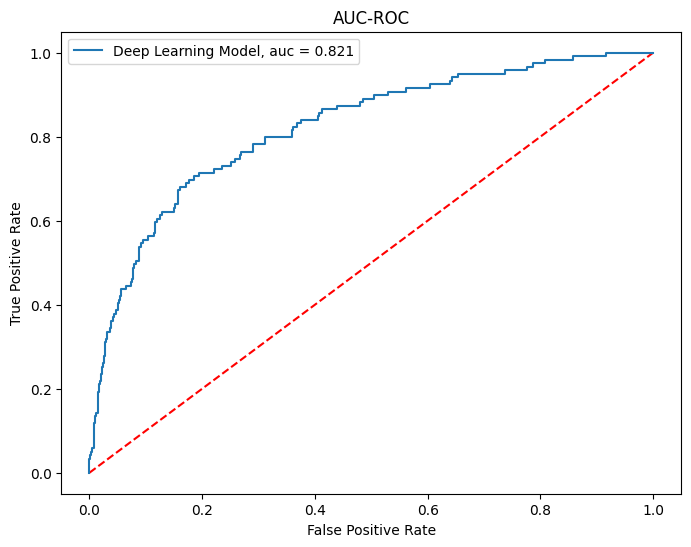

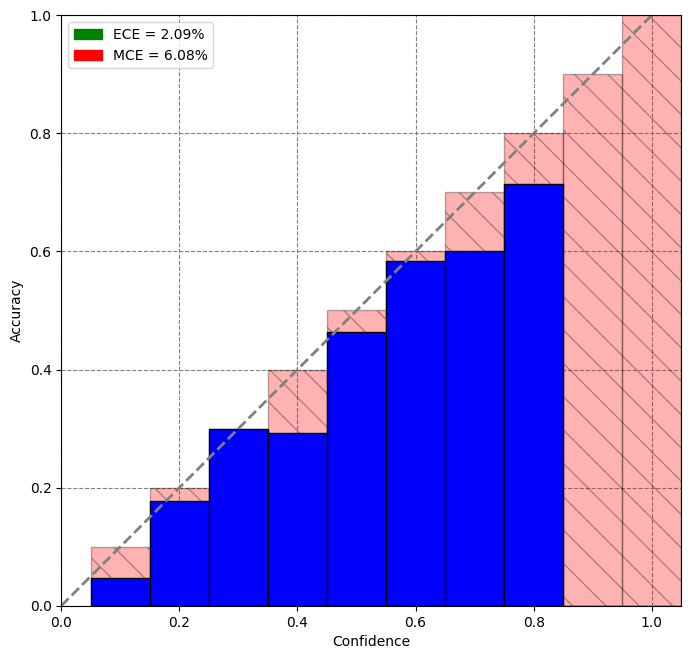

In [106]:
loss(prob,truth,logits,train=False,standalone=True)

In [93]:
output_df = pd.DataFrame()
output_df['Prob'] = prob
output_df['Logits'] = logits
output_df['Labels'] = truth

In [94]:
with open('./data/output/'+'outputDict_NODAB', 'wb') as fp:
    pickle.dump(output_df, fp)

In [74]:
# with open("./data/output/outputDict", 'rb') as fp:
#     outputDict=pickle.load(fp)
# prob=list(outputDict['Prob'])
# truth=list(outputDict['Labels'])
# logits=list(outputDict['Logits'])
# #print(torch.tensor(prob))
# print("======= TESTING ========")
# loss(prob,truth,logits,train=False,standalone=True)


### 11. FAIRNESS EVALUATION
In train and testing step we save output files in **./data/output/** folder.

This file conatins list of demographic variables included in training and testing of the model.

It also contains the ground truth labels and predicted probability for each sample.

We use the above saved data to perform fairness evaluation of the results obtained from model testing.

This module can be used as stand-alone module also.

Please create a file that contains predicted probabilites form the last sigmoid layer in column named **Prob** and
ground truth labels for each sample in column named **Labels**.

In [86]:
#fairness.fairness_evaluation(inputFile='outputDict_DAB1',outputFile='fairnessReport')

### 12. MODEL CALLIBRATION

Please run below cell if you want to callibrate predicted probabilites of the model on test data.
It will use the output saved during the testing of the model.

The file is saved in **./data/output/**.

This module can be used as stand-alone module also.

Please create a file that contain predicted logits form the last fully connected layer in column named **Logits** and <br>ground truth labels for each sample in a column named **Labels**.

BEFORE CALLIBRATION
BCE Loss: 1.81
AU-ROC: 0.82
AU-PRC: 0.44
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.61
Recall: 0.24
Specificity: 0.98
NPV: 0.90
ECE: 0.02
MCE: 0.06
AFTER CALLIBRATION
BCE Loss: 1.67
AU-ROC: 0.82
AU-PRC: 0.44
AU-PRC Baaseline: 0.12
Accuracy: 0.89
Precision: 0.61
Recall: 0.24
Specificity: 0.98
NPV: 0.90
ECE: 0.01
MCE: 0.28


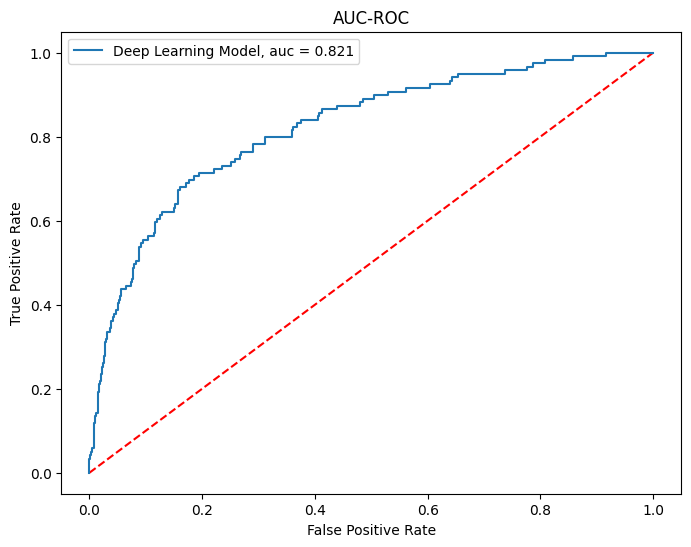

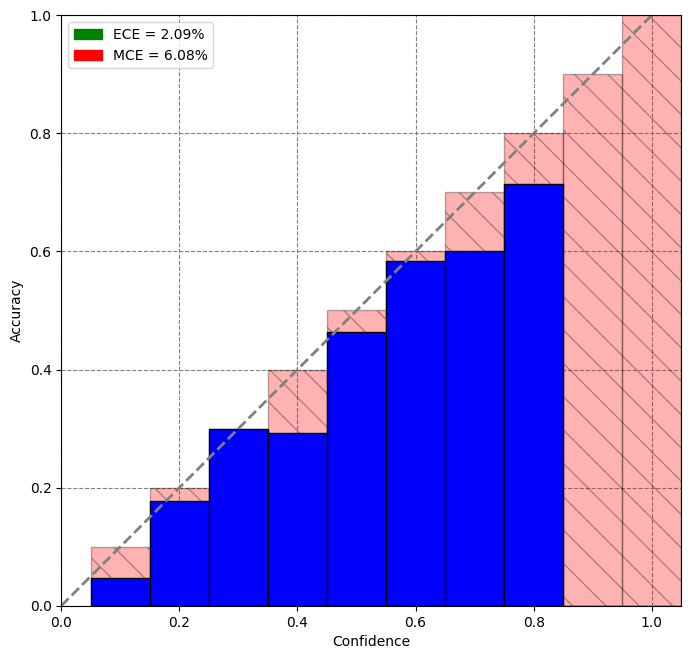

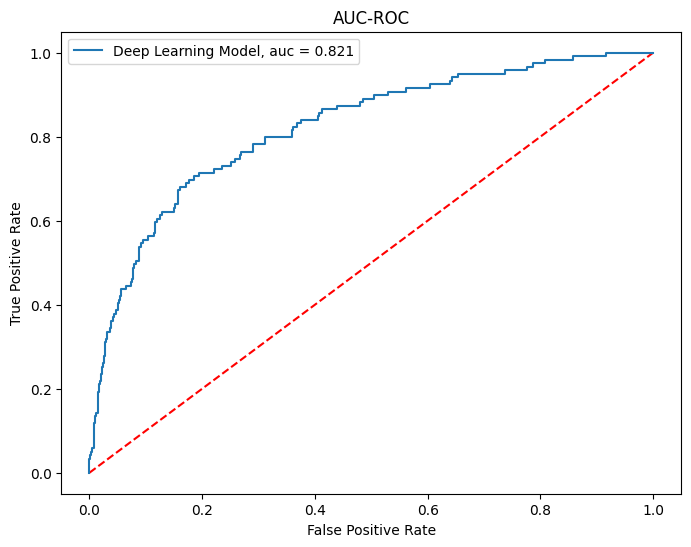

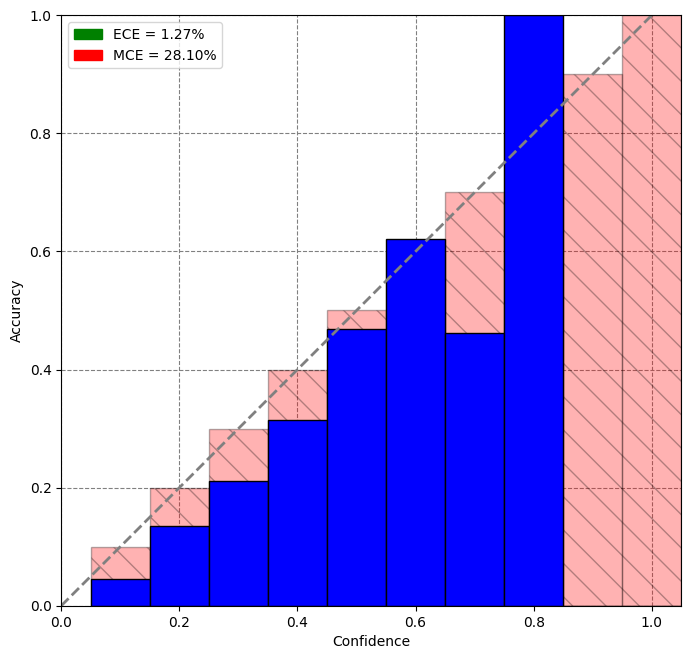

In [107]:
callibrate_output.callibrate(inputFile='outputDict_DAB1',outputFile='callibratedResults')